In [26]:
import pandas as pd
import numpy as np
import dill

from imblearn.pipeline import make_pipeline
from imblearn.ensemble import EasyEnsemble, BalanceCascade
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import auc, accuracy_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.base import BaseEstimator, ClassifierMixin

from scipy.stats import mode

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

In [27]:
class MYVC(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers=None):
        self.classifiers = classifiers

    def fit(self, X, y):
        for classifier in self.classifiers:
            classifier.fit(X, y)

    def predict_proba(self, X):
        self.predictions_ = list()
        for classifier in self.classifiers:
            self.predictions_.append(classifier.predict_proba(X))
        return np.mean(self.predictions_, axis=0)
    
    def predict(self, X):
        self.predictions_ = list()
        for classifier in self.classifiers:
            self.predictions_.append(classifier.predict(X))
        return mode(self.predictions_, axis=0).mode[0]

## Combine data

First read and normalize the features.

In [28]:
features = pd.read_pickle('../pkl/11_features_engineered.pkl').dropna()

feat_cols = [x for x in features.columns if x not in ['date','location']]

features[feat_cols] = Normalizer().fit_transform(features[feat_cols])

Import the predictors.

In [55]:
# framework_a_first = pd.read_pickle('../pkl/10_class_balancing_framework_a_first.pkl')
framework_a_first = pd.read_pickle('../pkl/10_class_balancing_fwf.pkl')

In [56]:
framework_a_first.columns

Index([u'location', u'cases_first_date', u'date', u'zika_bool'], dtype='object')

In [57]:
print framework_a_first.shape, framework_a_first.isnull().sum().max()

fwd_a_first = pd.merge(framework_a_first, 
                       features, 
                       on=['date','location'], how='left').dropna()

print fwd_a_first.shape, fwd_a_first.isnull().sum().max()

print fwd_a_first.zika_bool.value_counts()

(1605, 4) 0
(1143, 28) 0
1    949
0    194
Name: zika_bool, dtype: int64


Split the data into train and test portions.

In [58]:
train, test = train_test_split(fwd_a_first, test_size=0.30, random_state=42)

adasyn_3 = ADASYN(k=3)
X_resampled_3, Y_resampled_3 = adasyn_3.fit_sample(train[feat_cols], train['zika_bool'])

adasyn_5 = ADASYN(k=5)
X_resampled_5, Y_resampled_5 = adasyn_5.fit_sample(train[feat_cols], train['zika_bool'])

adasyn_7 = ADASYN(k=7)
X_resampled_7, Y_resampled_7 = adasyn_7.fit_sample(train[feat_cols], train['zika_bool'])

enn_3 = EditedNearestNeighbours(size_ngh=3)
X_dwnresampled_3, Y_dwnresampled_3 = enn_3.fit_sample(train[feat_cols], train['zika_bool'])

enn_5 = EditedNearestNeighbours(size_ngh=5)
X_dwnresampled_5, Y_dwnresampled_5 = enn_5.fit_sample(train[feat_cols], train['zika_bool'])

enn_7 = EditedNearestNeighbours(size_ngh=7)
X_dwnresampled_7, Y_dwnresampled_7 = enn_7.fit_sample(train[feat_cols], train['zika_bool'])

Ytest = test['zika_bool']
Xtest = test[feat_cols+['date','location']]

In [59]:
# data_names = ['unbalanced','upsampled_3','upsampled_5','upsampled_7',
#              'dwnsampled_3', 'dwnsampled_5', 'dwnsampled_7']
# xdata_list = [train[feat_cols], X_resampled_3, X_resampled_5, X_resampled_7, 
#               X_dwnresampled_3, X_dwnresampled_5, X_dwnresampled_7]
# ydata_list = [train['zika_bool'], Y_resampled_3, Y_resampled_5, Y_resampled_7, 
#               Y_dwnresampled_3, Y_dwnresampled_5, Y_dwnresampled_7]

# data_names = ['unbalanced','upsampled_3','dwnsampled_3']
# xdata_list = [train[feat_cols], X_resampled_3,X_dwnresampled_3]
# ydata_list = [train['zika_bool'], Y_resampled_3, Y_dwnresampled_3]

data_names = ['unbalanced','upsampled_3','upsampled_5',
             'dwnsampled_3', 'dwnsampled_5']
xdata_list = [train[feat_cols+['date','location']], X_resampled_3, X_resampled_5, 
              X_dwnresampled_3, X_dwnresampled_5]
ydata_list = [train['zika_bool'], Y_resampled_3, Y_resampled_5,
              Y_dwnresampled_3, Y_dwnresampled_5]

In [60]:
def error_calc(model, label, Ytest=Ytest):
    
    Ypred = model.predict(test[feat_cols])
    
    cm = confusion_matrix(Ytest, Ypred)
    f1 = f1_score(Ytest, Ypred)
    accuracy = accuracy_score(Ytest, Ypred)
    precision = precision_score(Ytest, Ypred)
    recall = recall_score(Ytest, Ypred)

    Yplot = model.predict_proba(Xtest[feat_cols])[:,1]

    xdata, ydata, _ = roc_curve(Ytest, Yplot)
    auc = roc_auc_score(Ytest, Yplot)

    df = pd.Series({'data':label,
                    'cm': cm, 'f1': f1, 
                    'accuracy':accuracy, 'auc':auc,
                    'precision':precision, 'recall':recall,
                    'roc_x': xdata, 'roc_y': ydata, 'model':model})
    return df

## Logistic regression

In [24]:
logistic_list = list()

param_grid = [{'C':[0.001,0.01,0.1,1,10,100,1000], 'penalty':['l1'], 'solver':['liblinear']},
              {'C':[0.001,0.01,0.1,1,10,100,1000], 'penalty':['l2']}]
        
MOD = LogisticRegression()        
CV = GridSearchCV(MOD, param_grid)

for Xtrain,Ytrain,name in zip(xdata_list, ydata_list, data_names):
    print name
    CV.fit(Xtrain, Ytrain)
    
    df = error_calc(CV, name)
    
    logistic_list.append(df)

unbalanced
upsampled_3
upsampled_5
dwnsampled_3
dwnsampled_5


In [25]:
logistic_results = (pd.concat(logistic_list, axis=1).T
                    .set_index('data'))
logistic_results[['accuracy','f1','recall','precision','auc', 'cm']]

,accuracy,f1,recall,precision,auc,cm
data,,,,,,
unbalanced,0.87172,0.92517,0.97491,0.880259,0.839018,"[[27, 37], [7, 272]]"
upsampled_3,0.819242,0.881679,0.827957,0.942857,0.854867,"[[50, 14], [48, 231]]"
upsampled_5,0.822157,0.88381,0.831541,0.943089,0.858843,"[[50, 14], [47, 232]]"
dwnsampled_3,0.868805,0.921739,0.949821,0.89527,0.824401,"[[33, 31], [14, 265]]"
dwnsampled_5,0.868805,0.921466,0.946237,0.897959,0.832185,"[[34, 30], [15, 264]]"


In [64]:
tmp = logistic_results.loc['unbalanced','model']

In [66]:
a = tmp.best_estimator_

In [81]:
tmp2 = np.array(feat_cols)
tmp2[np.abs(a.coef_).argsort()]

array([['max_temp1', 'max_temp2', 'mean_temp1', 'min_temp',
        'precipitation2', 'precipitation1', 'precipitation',
        'density_per_km', 'gdp', 'gdp_ppp', 'wind', 'dew_point1',
        'mean_temp', 'airport_dist_any', 'max_temp', 'airport_dist_large',
        'wind2', 'min_temp1', 'min_temp2', 'mosquito_dist', 'dew_point2',
        'mean_temp2', 'wind1', 'dew_point']], 
      dtype='|S18')

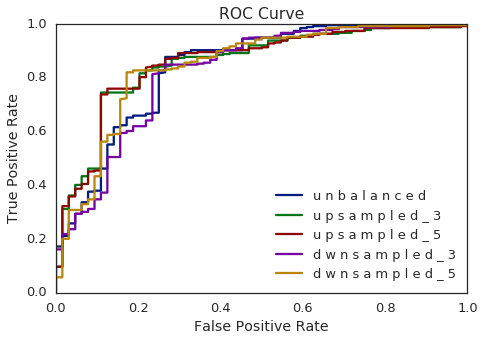

In [11]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

colors = sns.color_palette()

for idx,dat in logistic_results.iterrows():
    label = ' '.join(idx)
    xdata = dat.roc_x
    ydata = dat.roc_y
    ax.plot(xdata, ydata, label=label)

ax.legend(loc=0)

_ = ax.set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='ROC Curve')

plt.tight_layout()

## Random Forest Classifier

In [15]:
random_forest_list = list()

param_grid = {'max_depth':range(5,10), 'n_estimators':[300,400,500], 
              'class_weight':['balanced','balanced_subsample']}
        
MOD = RandomForestClassifier(n_jobs=-1,random_state=42, oob_score=True)
CV = GridSearchCV(MOD, param_grid)

for Xtrain,Ytrain,name in zip(xdata_list, ydata_list, data_names):
    print name
    CV.fit(Xtrain, Ytrain)
    
    df = error_calc(CV, name)
    
    random_forest_list.append(df)

unbalanced
upsampled_3
upsampled_5
dwnsampled_3
dwnsampled_5


In [16]:
random_forest_results = (pd.concat(random_forest_list, axis=1).T
                         .set_index('data'))
random_forest_results[['accuracy','f1','recall','precision','auc', 'cm']]

,accuracy,f1,recall,precision,auc,cm
data,,,,,,
unbalanced,0.900875,0.940351,0.960573,0.920962,0.890121,"[[41, 23], [11, 268]]"
upsampled_3,0.895044,0.935714,0.939068,0.932384,0.884381,"[[45, 19], [17, 262]]"
upsampled_5,0.889213,0.9319,0.9319,0.9319,0.885193,"[[45, 19], [19, 260]]"
dwnsampled_3,0.883382,0.928315,0.928315,0.928315,0.883149,"[[44, 20], [20, 259]]"
dwnsampled_5,0.865889,0.916058,0.899642,0.933086,0.87654,"[[46, 18], [28, 251]]"


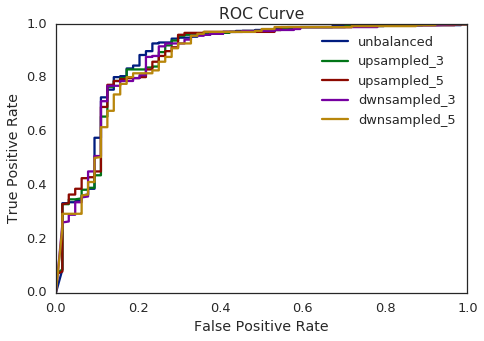

In [17]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

colors = sns.color_palette()

for idx,dat in random_forest_results.iterrows():
    label = idx
    xdata = dat.roc_x
    ydata = dat.roc_y
    ax.plot(xdata, ydata, label=label)

ax.legend(loc=0)

_ = ax.set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='ROC Curve')

plt.tight_layout()

## AdaBoost classification

In [61]:
ada_list = list()

param_grid = {'learning_rate':[0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 
              'n_estimators':[300,400,500]}

# param_grid = {'learning_rate':[0.1], 
#               'n_estimators':[500]}
        
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
MOD = AdaBoostClassifier(base_estimator=tree,
                            random_state=42)
CV = GridSearchCV(MOD, param_grid)

for Xtrain,Ytrain,name in zip(xdata_list, ydata_list, data_names):
    print name
    if name == 'unbalanced':
        
        #Xtrain = pd.DataFrame(Xtrain,columns=feat_cols)
        Xtrain.to_pickle('../pkl/13_model_tuning_Xtrain_ada_inner_{}.pkl'.format(name))

        #Ytrain = pd.DataFrame(Ytrain,columns=['zika_bool'])
        Ytrain.to_pickle('../pkl/13_model_tuning_Ytrain_ada_inner_{}.pkl'.format(name))

        Xtest.to_pickle('../pkl/13_model_tuning_Xtest_ada_inner_{}.pkl'.format(name))
        Ytest.to_pickle('../pkl/13_model_tuning_Ytest_ada_inner_{}.pkl'.format(name))

        CV.fit(Xtrain[feat_cols], Ytrain)

        with open('../pkl/13_model_tuning_ada_models_inner_{}.pkl'.format(name),'w') as fh:
            dill.dump(CV,fh)

        Ypred_test = pd.DataFrame(CV.predict(Xtest[feat_cols]), 
                                  columns=['zika_bool'],
                                  index=Xtest.index)
        
        Ypred_train = pd.DataFrame(CV.predict(Xtrain[feat_cols]), 
                                   columns=['zika_bool'],
                                   index=Xtrain.index)

        Ypred_test.to_pickle('../pkl/13_model_tuning_Ypred_test_ada_inner_{}.pkl'.format(name))
        Ypred_train.to_pickle('../pkl/13_model_tuning_Ypred_train_ada_inner_{}.pkl'.format(name))

        print confusion_matrix(Ytest, Ypred_test)

        df = error_calc(CV, name)

        ada_list.append(df)



unbalanced
[[ 35  29]
 [  5 274]]
upsampled_3
upsampled_5
dwnsampled_3
dwnsampled_5


In [13]:
ada_results = pd.concat(ada_list, axis=1).T.set_index('data')
ada_results[['accuracy','f1','recall','precision','auc', 'cm']]

,accuracy,f1,recall,precision,auc,cm
data,,,,,,
unbalanced,0.900875,0.941581,0.982079,0.90429,0.885333,"[[35, 29], [5, 274]]"
upsampled_3,0.892128,0.934281,0.942652,0.926056,0.883513,"[[43, 21], [16, 263]]"
upsampled_5,0.889213,0.932143,0.935484,0.928826,0.879984,"[[44, 20], [18, 261]]"
dwnsampled_3,0.87172,0.920578,0.913978,0.927273,0.874272,"[[44, 20], [24, 255]]"
dwnsampled_5,0.851312,0.90573,0.878136,0.935115,0.878248,"[[47, 17], [34, 245]]"


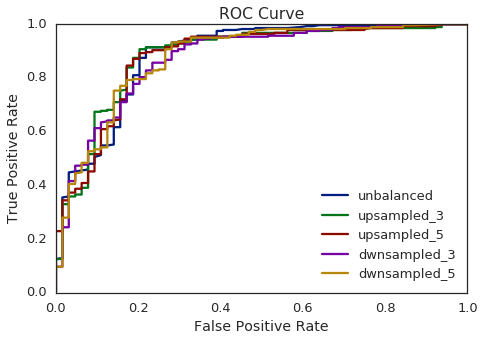

In [14]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

colors = sns.color_palette()

for idx,dat in ada_results.iterrows():
    label = idx
    xdata = dat.roc_x
    ydata = dat.roc_y
    ax.plot(xdata, ydata, label=label)

ax.legend(loc=0)

_ = ax.set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='ROC Curve')

plt.tight_layout()

In [23]:
logistic_results.to_pickle('../pkl/13_model_tuning_logistic_models_df.pkl')

for idx,row in logistic_results.iterrows():
    print idx
    with open('../pkl/13_model_tuning_logistic_{}.pkl'.format(idx),'w') as fh:
        dill.dump(row.model,fh)

unbalanced
upsampled_3
upsampled_5
dwnsampled_3
dwnsampled_5


In [24]:
random_forest_results.to_pickle('../pkl/13_model_tuning_random_forest_models_df.pkl')

for idx,row in random_forest_results.iterrows():
    print idx
    with open('../pkl/13_model_tuning_random_forest_{}.pkl'.format(idx),'w') as fh:
        dill.dump(row.model,fh)

unbalanced
upsampled_3
upsampled_5
dwnsampled_3
dwnsampled_5


In [25]:
ada_results.to_pickle('../pkl/13_model_tuning_ada_models_df.pkl')

for idx,row in ada_results.iterrows():
    print idx
    with open('../pkl/13_model_tuning_ada_models_{}.pkl'.format(idx),'w') as fh:
        dill.dump(row.model,fh)

unbalanced
upsampled_3
upsampled_5
dwnsampled_3
dwnsampled_5
